In [21]:
import pyqg
import xarray as xr
import matplotlib.pyplot as plt
from pyqg_generative.tools.comparison_tools import dataset_smart_read, distrib_score, spectral_score
from pyqg_generative.tools.operators import ave_lev
from pyqg_generative.tools.operators import Operator1, Operator2, PV_subgrid_forcing, ave_lev, coord
from pyqg_generative.tools.spectral_tools import calc_ispec, coord, spectrum
from pyqg_generative.tools.simulate import run_simulation
from pyqg_generative.tools.parameters import *
import pyqg_generative.tools.operators as op
from pyqg_generative.tools.plot_helpers import *

In [7]:
def compute_flux(ds, delta=0.25):
    ds = ds.expand_dims('run')
    ds['time'] = ds['time'] / 360
    ds['time'].attrs = {'long_name':'time [$years$]'}
    stats = xr.Dataset()
    m = pyqg.QGModel(nx=len(ds.x), log_level=0)
    for key in ['APEflux', 'APEgenspec', 'Dissspec', 'ENSDissspec', 
        'ENSflux', 'ENSfrictionspec', 'ENSgenspec', 'ENSparamspec', 
        'Ensspec', 'KEflux', 'KEfrictionspec', 'KEspec', 'entspec', 
        'paramspec', 'paramspec_APEflux', 'paramspec_KEflux']:
        if key not in ds.keys():
            continue
        var = ds[key].mean(dim='run')
        if 'lev' in var.dims:
            sps = []
            for z in [0,1]:
                k, sp = calc_ispec(m, var.isel(lev=z).values)
                sps.append(sp)
            sp = np.stack(sps, axis=0)
            stats[key+'r'] = \
                xr.DataArray(sp, dims=['lev', 'kr'],
                coords=[[1,2], coord(k, 'wavenumber, $m^{-1}$')])

            var_mean = op.ave_lev(var, delta)
            k, sp = calc_ispec(m, var_mean.values)
            stats[key+'r_mean'] = \
                xr.DataArray(sp, dims=['kr'],
                coords=[coord(k, 'wavenumber, $m^{-1}$')])
        else:
            k, sp = calc_ispec(m, var.values)
            stats[key+'r'] = \
                xr.DataArray(sp, dims=['kr'],
                coords=[coord(k, 'wavenumber, $m^{-1}$')])

    budget_sum = 0
    for key in ['KEfluxr', 'APEfluxr', 'APEgenspecr', 'KEfrictionspecr', 
        'paramspec_APEfluxr', 'paramspec_KEfluxr']:
        if key in stats.keys():
            budget_sum += stats[key]
    stats['Energysumr'] = budget_sum

    Eflux = 0
    for key in ['KEfluxr', 'APEfluxr', 'paramspec_KEfluxr', 'paramspec_APEfluxr']:
        if key in stats.keys():
            Eflux = Eflux + stats[key]
    stats['Efluxr'] = Eflux
    def KE(ds):
        return (ds.u**2 + ds.v**2) * 0.5
    def KE_time(ds):
        return op.ave_lev(KE(ds), delta=delta).mean(('run', 'x', 'y'))
    stats['KE_time'] = KE_time(ds)
    return stats

# Online experiment with Reynolds model

In [2]:
import pyqg.parameterizations as pyqg_p

In [205]:
p = {}
p['self'] = pyqg_p.Reynolds_stress(Csim=7)
p['sampling']='constant'
p['nsteps']=1

In [206]:
p['self']

Reynolds, FGR=2, Csim=7

In [207]:
sim = run_simulation(EDDY_PARAMS.nx(64)._update({'tmax':20*YEAR}), p)

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 8.66e-07, CFL: 0.023
INFO: Step: 2000, Time years:  0.9, KE: 4.56e-06, CFL: 0.023
INFO: Step: 3000, Time years:  1.4, KE: 3.18e-05, CFL: 0.039
INFO: Step: 4000, Time years:  1.9, KE: 2.50e-04, CFL: 0.109
INFO: Step: 5000, Time years:  2.3, KE: 5.70e-04, CFL: 0.209
INFO: Step: 6000, Time years:  2.8, KE: 5.99e-04, CFL: 0.218
INFO: Step: 7000, Time years:  3.2, KE: 5.94e-04, CFL: 0.183
INFO: Step: 8000, Time years:  3.7, KE: 6.15e-04, CFL: 0.219
INFO: Step: 9000, Time years:  4.2, KE: 6.14e-04, CFL: 0.214
INFO: Step: 10000, Time years:  4.6, KE: 6.35e-04, CFL: 0.219
INFO: Step: 11000, Time years:  5.1, KE: 5.27e-04, CFL: 0.183
INFO: Step: 12000, Time years:  5.6, KE: 5.41e-04, CFL: 0.186
INFO: Step: 13000, Time years:  6.0, KE: 5.68e-04, CFL: 0.178
INFO: Step: 14000, Time years:  6.5, KE: 6.33e-04, CFL: 0.229
INFO: Step: 15000, Time years:  6.9, KE: 6.41e-04, CFL: 0.203
INFO: Step: 16000, Time years:  7.4, KE: 5.68e-04, CF

Function 'concat_in_time' executed in 0.3194s
Function 'run_simulation' executed in 91.3540s


In [208]:
rey_online = compute_flux(sim)

# Compare to reference simulations

In [177]:
ds = {}
for res in ['48', '64', '96', '256']:
    ds[res] = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_{res}/[0-9].nc', delta=0.25)    

In [178]:
ds['rey_48'] = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/ReynoldsStress-0/eddy-constant-0/[0-9].nc',delta=0.25)


In [179]:
ds['rey_64'] = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-64/ReynoldsStress-0/eddy-constant-0/[0-9].nc',delta=0.25)


In [180]:
ds['rey_96'] = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-96/ReynoldsStress-0/eddy-constant-0/[0-9].nc',delta=0.25)


In [218]:
ds['Jansen_48'] = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/BackscatterEddy-0/eddy-constant-0/[0-9].nc', delta=0.25)
ds['Jansen_64'] = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-64/BackscatterEddy-0/eddy-constant-0/[0-9].nc', delta=0.25)
ds['Jansen_96'] = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-96/BackscatterEddy-0/eddy-constant-0/[0-9].nc', delta=0.25)

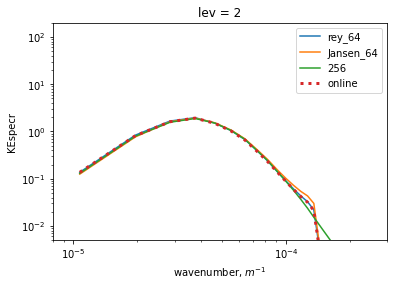

In [222]:
ls = ['-','-','-','--']
for j,key in enumerate(['rey_64', 'Jansen_64', '256']):
    (0.5*ds[key].KEspecr.isel(lev=1)).plot(label=key,ls=ls[j])
plt.xscale('log')
plt.yscale('log')
plt.ylim([5e-3, 2e+2])
plt.xlim([8e-6,3e-4])
plt.ylabel('KE spectrum, $E(\kappa), m^3/s^2$')
plt.xlabel(r'wavenumber $\kappa, m^{-1}$')
(0.5*rey_online.KEspecr.isel(lev=1)).plot(ls=':', lw=3,label='online')
plt.legend()

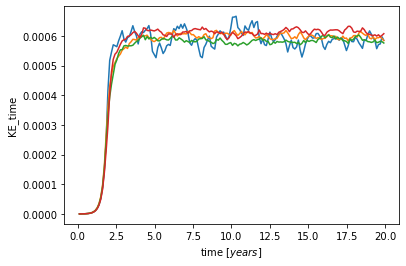

In [223]:
rey_online.KE_time.plot()
ds['rey_64'].KE_time.plot()
ds['Jansen_64'].KE_time.plot()
ds['256'].KE_time.plot()

# Figure for paper

In [2]:
ds = {}
for res in ['64', '256']:
    ds[res] = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_{res}/[0-9].nc', delta=0.25)    
ds['rey_64'] = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-64/ReynoldsStress-0/eddy-constant-0/[0-9].nc',delta=0.25)
ds['Jansen_64'] = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-64/BackscatterEddy-0/eddy-constant-0/[0-9].nc', delta=0.25)
for key in ds.keys():
    ds[key]['KEspecr_mean'] = ds[key].KEspecr_mean/2

In [3]:
from pyqg_generative.tools.plot_helpers import *

In [4]:
default_rcParams({'font.size': 14,
        'axes.labelsize': 14,
        'axes.titlesize': 14,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'figure.subplot.hspace': 0.6,
        'axes.titlelocation' : 'right'})

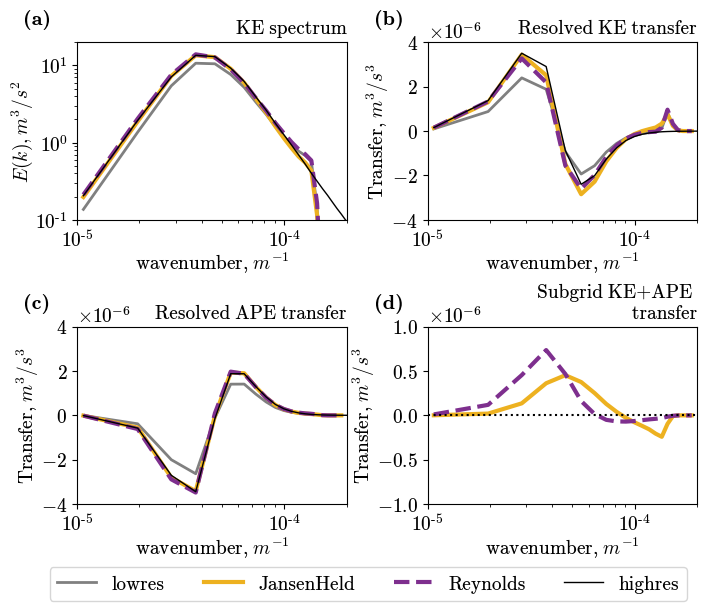

In [7]:
plt.figure(figsize=(8,6))
for j,key in enumerate(['KEspecr_mean', 'KEfluxr', 'APEfluxr', 'paramspecr']):
    plt.subplot(2,2,j+1)
    if key != 'paramspecr':
        ds['64'][key].plot(color='gray', label='lowres', lw=2)
    ds['Jansen_64'][key].plot(color=[0.9290,0.6940,0.1250], lw=3,label='JansenHeld')
    ds['rey_64'][key].plot(color=[0.4940,0.1840,0.5560], ls='--', lw=3,label='Reynolds')
    if key != 'paramspecr':
        ds['256'][key].plot(color='k', lw=1, label='highres')
    plt.xlim([1e-5,2e-4])
    plt.xscale('log')
set_letters(x=-0.2,y=1.1,fontsize=14)
plt.subplot(2,2,1)
plt.yscale('log')
plt.ylim([1e-1,2e1])
plt.ylabel('$E(k), m^3/s^2$')
plt.title('KE spectrum')
plt.subplot(2,2,2)
plt.ylabel('Transfer, $m^3/s^3$')
plt.title('Resolved KE transfer')
plt.ylim([-4e-6,4e-6])
plt.subplot(2,2,3)
plt.ylabel('Transfer, $m^3/s^3$')
plt.title('Resolved APE transfer')
plt.legend(bbox_to_anchor=(2.3,-0.3),ncol=4)
plt.ylim([-4e-6,4e-6])
plt.subplot(2,2,4)
plt.ylabel('Transfer, $m^3/s^3$')
plt.title('Subgrid KE+APE \n transfer')
plt.ylim([-1e-6,1e-6])
plt.axhline(ls=':', color='k')
plt.savefig('pyqg.pdf')

# Jet solution

In [3]:
ds = {}
for res in ['48', '64', '96', '256']:
    ds[res] = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet_40years/reference_{res}/[0-9].nc', delta=0.1)    

In [9]:
ds['rey_48'] = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_jet_40years/Operator1-48/ReynoldsStress-0/jet-constant-0/[0-9].nc',delta=0.1)
ds['rey_64'] = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_jet_40years/Operator1-64/ReynoldsStress-0/jet-constant-0/[0-9].nc',delta=0.1)


In [52]:
p = {}
p['self'] = pyqg_p.Reynolds_stress(Csim=12)
p['sampling']='constant'
p['nsteps']=1

In [53]:
rey = run_simulation(JET_PARAMS.nx(64)._update({'tmax':40*YEAR}), p)

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 1.71e-07, CFL: 0.023
INFO: Step: 2000, Time years:  0.9, KE: 2.20e-07, CFL: 0.023
INFO: Step: 3000, Time years:  1.4, KE: 4.22e-07, CFL: 0.023
INFO: Step: 4000, Time years:  1.9, KE: 1.02e-06, CFL: 0.023
INFO: Step: 5000, Time years:  2.3, KE: 2.87e-06, CFL: 0.023
INFO: Step: 6000, Time years:  2.8, KE: 8.85e-06, CFL: 0.027
INFO: Step: 7000, Time years:  3.2, KE: 2.88e-05, CFL: 0.046
INFO: Step: 8000, Time years:  3.7, KE: 9.67e-05, CFL: 0.079
INFO: Step: 9000, Time years:  4.2, KE: 2.11e-04, CFL: 0.132
INFO: Step: 10000, Time years:  4.6, KE: 1.79e-04, CFL: 0.146
INFO: Step: 11000, Time years:  5.1, KE: 1.48e-04, CFL: 0.156
INFO: Step: 12000, Time years:  5.6, KE: 1.32e-04, CFL: 0.118
INFO: Step: 13000, Time years:  6.0, KE: 1.25e-04, CFL: 0.139
INFO: Step: 14000, Time years:  6.5, KE: 1.39e-04, CFL: 0.131
INFO: Step: 15000, Time years:  6.9, KE: 1.83e-04, CFL: 0.161
INFO: Step: 16000, Time years:  7.4, KE: 1.71e-04, CF

Function 'concat_in_time' executed in 1.0245s
Function 'run_simulation' executed in 184.5367s


In [55]:
rey_online = compute_flux(rey)

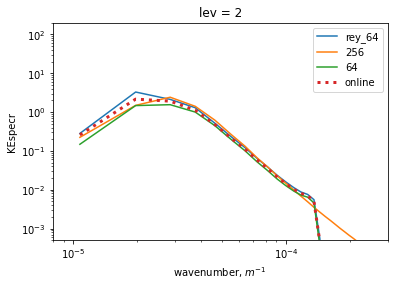

In [19]:
ls = ['-','-','-','--']
for j,key in enumerate(['rey_64', '256', '64']):
    (0.5*ds[key].KEspecr.isel(lev=1)).plot(label=key,ls=ls[j])
plt.xscale('log')
plt.yscale('log')
plt.ylim([5e-4, 2e+2])
plt.xlim([8e-6,3e-4])
plt.ylabel('KE spectrum, $E(\kappa), m^3/s^2$')
plt.xlabel(r'wavenumber $\kappa, m^{-1}$')
(0.5*rey_online.KEspecr.isel(lev=1)).plot(ls=':', lw=3,label='online')
plt.legend()

In [83]:
p = {}
p['self'] = pyqg_p.Reynolds_stress(Csim=20) + pyqg.ADM(order=0)
p['sampling']='constant'
p['nsteps']=1
ssm_rey = run_simulation(JET_PARAMS.nx(64)._update({'tmax':40*YEAR}), p)

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 3.00e-07, CFL: 0.023
INFO: Step: 2000, Time years:  0.9, KE: 2.12e-07, CFL: 0.023
INFO: Step: 3000, Time years:  1.4, KE: 2.81e-07, CFL: 0.023
INFO: Step: 4000, Time years:  1.9, KE: 4.71e-07, CFL: 0.023
INFO: Step: 5000, Time years:  2.3, KE: 9.34e-07, CFL: 0.024
INFO: Step: 6000, Time years:  2.8, KE: 2.17e-06, CFL: 0.024
INFO: Step: 7000, Time years:  3.2, KE: 5.79e-06, CFL: 0.024
INFO: Step: 8000, Time years:  3.7, KE: 1.71e-05, CFL: 0.034
INFO: Step: 9000, Time years:  4.2, KE: 5.41e-05, CFL: 0.056
INFO: Step: 10000, Time years:  4.6, KE: 1.62e-04, CFL: 0.103
INFO: Step: 11000, Time years:  5.1, KE: 1.61e-04, CFL: 0.140
INFO: Step: 12000, Time years:  5.6, KE: 1.25e-04, CFL: 0.127
INFO: Step: 13000, Time years:  6.0, KE: 1.38e-04, CFL: 0.129
INFO: Step: 14000, Time years:  6.5, KE: 1.34e-04, CFL: 0.126
INFO: Step: 15000, Time years:  6.9, KE: 1.19e-04, CFL: 0.129
INFO: Step: 16000, Time years:  7.4, KE: 1.22e-04, CF

Function 'concat_in_time' executed in 0.6150s
Function 'run_simulation' executed in 273.3378s


In [38]:
p = {}
p['self'] = pyqg.ADM(order=0)
p['sampling']='constant'
p['nsteps']=1
ssm = run_simulation(JET_PARAMS.nx(64)._update({'tmax':40*YEAR}), p)

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 2.32e-07, CFL: 0.023
INFO: Step: 2000, Time years:  0.9, KE: 2.86e-07, CFL: 0.023
INFO: Step: 3000, Time years:  1.4, KE: 6.22e-07, CFL: 0.023
INFO: Step: 4000, Time years:  1.9, KE: 1.73e-06, CFL: 0.023
INFO: Step: 5000, Time years:  2.3, KE: 5.49e-06, CFL: 0.023
INFO: Step: 6000, Time years:  2.8, KE: 1.86e-05, CFL: 0.032
INFO: Step: 7000, Time years:  3.2, KE: 6.52e-05, CFL: 0.056
INFO: Step: 8000, Time years:  3.7, KE: 2.22e-04, CFL: 0.116
INFO: Step: 9000, Time years:  4.2, KE: 1.92e-04, CFL: 0.141
INFO: Step: 10000, Time years:  4.6, KE: 1.46e-04, CFL: 0.151
INFO: Step: 11000, Time years:  5.1, KE: 1.50e-04, CFL: 0.145
INFO: Step: 12000, Time years:  5.6, KE: 1.72e-04, CFL: 0.179
INFO: Step: 13000, Time years:  6.0, KE: 1.63e-04, CFL: 0.151
INFO: Step: 14000, Time years:  6.5, KE: 1.52e-04, CFL: 0.142
INFO: Step: 15000, Time years:  6.9, KE: 1.48e-04, CFL: 0.135
INFO: Step: 16000, Time years:  7.4, KE: 1.39e-04, CF

Function 'concat_in_time' executed in 0.6336s
Function 'run_simulation' executed in 176.1873s


In [84]:
ssm_online = compute_flux(ssm)
ssm_rey_online = compute_flux(ssm_rey)

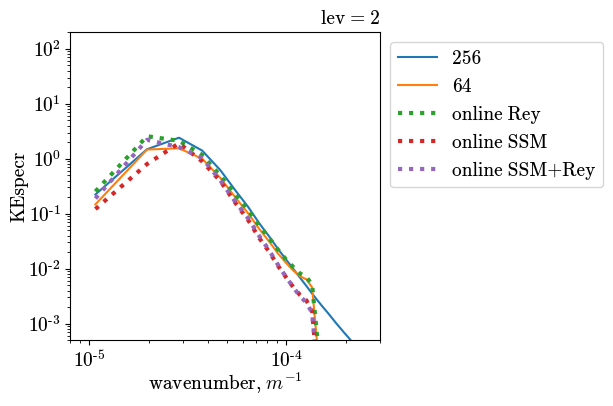

In [92]:
ls = ['-','-','-','--']
for j,key in enumerate(['256', '64']):
    (0.5*ds[key].KEspecr.isel(lev=1)).plot(label=key,ls=ls[j])
plt.xscale('log')
plt.yscale('log')
plt.ylim([5e-4, 2e+2])
plt.xlim([8e-6,3e-4])
plt.ylabel('KE spectrum, $E(\kappa), m^3/s^2$')
plt.xlabel(r'wavenumber $\kappa, m^{-1}$')
(0.5*rey_online.KEspecr.isel(lev=1)).plot(ls=':', lw=3,label='online Rey')
(0.5*ssm_online.KEspecr.isel(lev=1)).plot(ls=':', lw=3,label='online SSM')
(0.5*ssm_rey_online.KEspecr.isel(lev=1)).plot(ls=':', lw=3,label='online SSM+Rey')
plt.legend(bbox_to_anchor=(1,1))

In [60]:
def KE(ds):
    return (ds.u**2+ds.v**2)/2

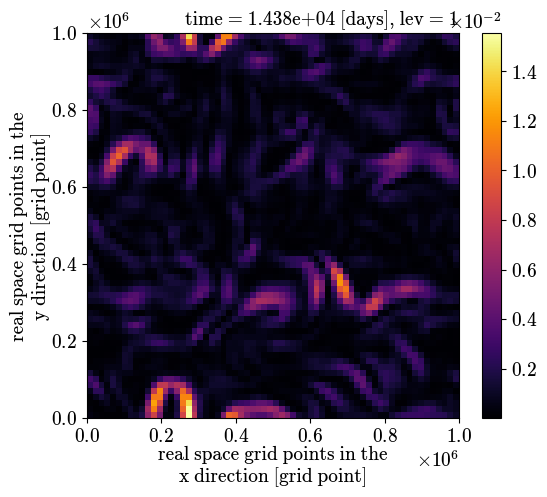

In [94]:
plt.figure(figsize=(6,5))
KE(ssm_rey).isel(time=-1,lev=0).plot(cmap='inferno')

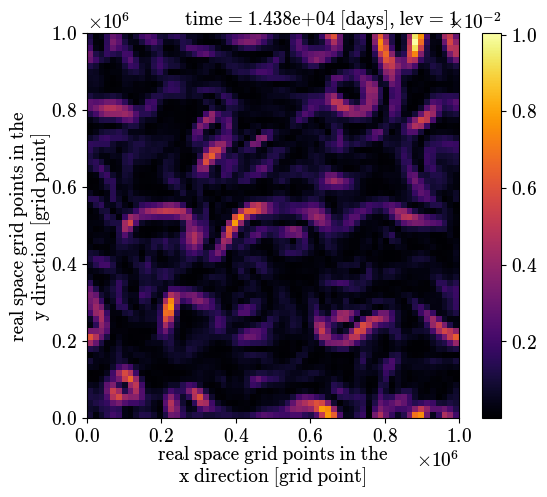

In [93]:
plt.figure(figsize=(6,5))
KE(ssm).isel(time=-1,lev=0).plot(cmap='inferno')

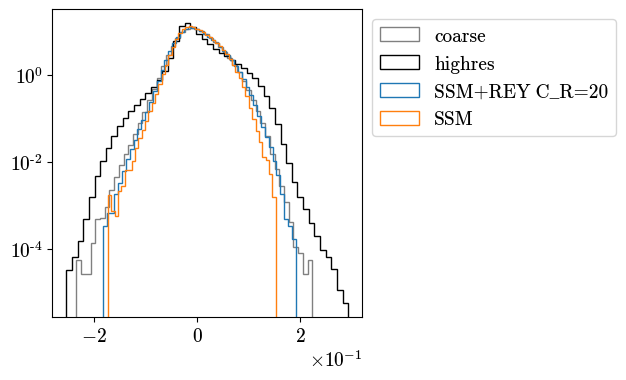

In [95]:
plt.hist(ds['64'].u.isel(time=slice(-100,None),lev=0).values.ravel(),50,density=True, histtype='step', label='coarse',color='gray');
plt.hist(ds['256'].u.isel(time=slice(-100,None),lev=0).values.ravel(),50,density=True, histtype='step', label='highres',color='k');
plt.hist(ssm_rey.u.isel(time=slice(-200,None),lev=0).values.ravel(),50,density=True, histtype='step', label='SSM+REY C_R=20');
plt.hist(ssm.u.isel(time=slice(-200,None),lev=0).values.ravel(),50,density=True,histtype='step', label='SSM');
#plt.hist(rey.u.isel(time=slice(-200,None),lev=0).values.ravel(),50,density=True,histtype='step', label='REY');
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1))

In [25]:
default_rcParams({'font.size': 14,
        'axes.labelsize': 14,
        'axes.titlesize': 14,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'figure.subplot.hspace': 0.6,
        'axes.titlelocation' : 'right'})

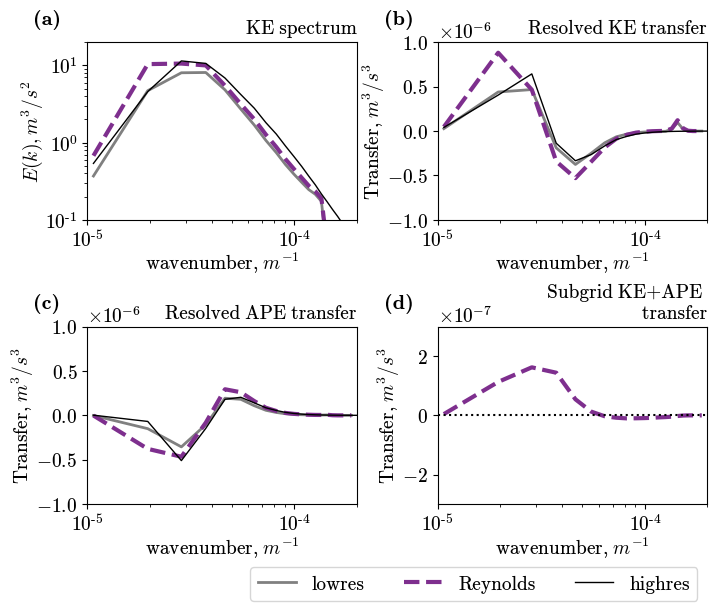

In [36]:

plt.figure(figsize=(8,6))
for j,key in enumerate(['KEspecr_mean', 'KEfluxr', 'APEfluxr', 'paramspecr']):
    plt.subplot(2,2,j+1)
    if key != 'paramspecr':
        ds['64'][key].plot(color='gray', label='lowres', lw=2)
    #ds['Jansen_64'][key].plot(color=[0.9290,0.6940,0.1250], lw=3,label='JansenHeld')
    ds['rey_64'][key].plot(color=[0.4940,0.1840,0.5560], ls='--', lw=3,label='Reynolds')
    if key != 'paramspecr':
        ds['256'][key].plot(color='k', lw=1, label='highres')
    plt.xlim([1e-5,2e-4])
    plt.xscale('log')
set_letters(x=-0.2,y=1.1,fontsize=14)
plt.subplot(2,2,1)
plt.yscale('log')
plt.ylim([1e-1,2e1])
plt.ylabel('$E(k), m^3/s^2$')
plt.title('KE spectrum')
plt.subplot(2,2,2)
plt.ylabel('Transfer, $m^3/s^3$')
plt.title('Resolved KE transfer')
plt.ylim([-1e-6,1e-6])
plt.subplot(2,2,3)
plt.ylabel('Transfer, $m^3/s^3$')
plt.title('Resolved APE transfer')
plt.legend(bbox_to_anchor=(2.3,-0.3),ncol=4)
plt.ylim([-1e-6,1e-6])
plt.subplot(2,2,4)
plt.ylabel('Transfer, $m^3/s^3$')
plt.title('Subgrid KE+APE \n transfer')
plt.ylim([-3e-7,3e-7])
plt.axhline(ls=':', color='k')
#plt.savefig('pyqg.pdf')